# Package Import

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset

import os, sys
import numpy as np
import pandas as pd
from tqdm import tqdm
import ipywidgets as widgets
import matplotlib.pyplot as plt
from ipywidgets import interact
from IPython.display import clear_output

from model import FCVAE
from loss import criterion, kl_divergence, log_likelihood

# Hyperparameters Setup

In [2]:
n_dim = 240
n_hid1 = 30
n_hid2 = 15
n_seq = 10
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"
sys.dont_write_bytecode = True

## [mock data]

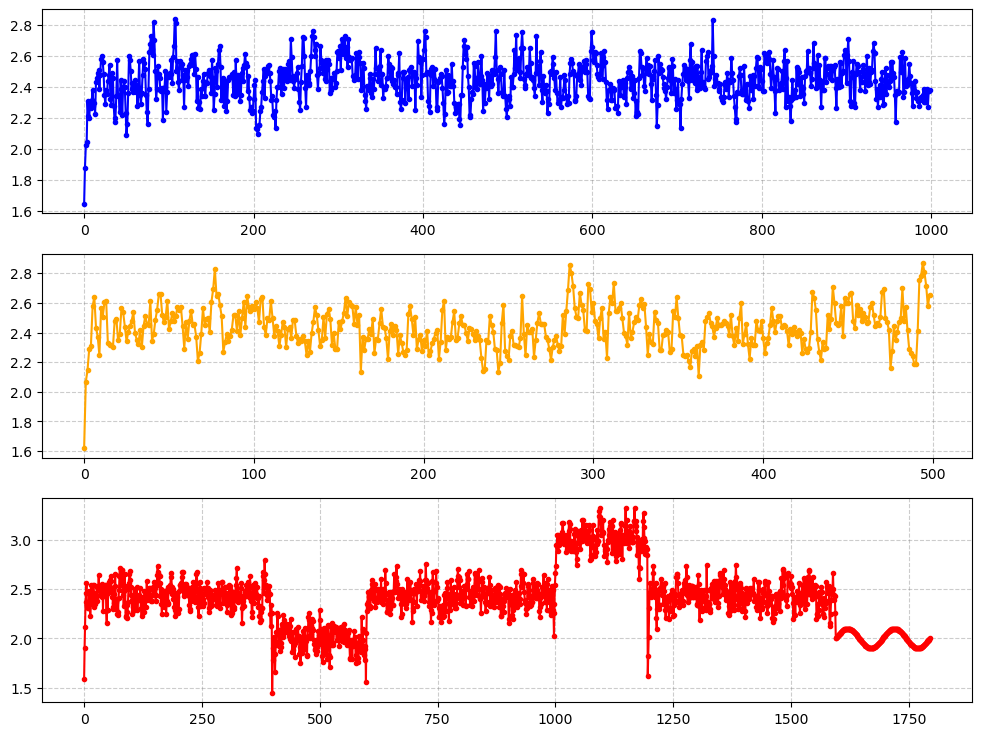

In [3]:
def gen_sample(init_val, beta, n_size):
    res = list()
    res += [init_val]
    for i in range(n_size-1):
        res += [res[-1]*beta + init_val + np.random.normal(0, 0.1)]
    return res[1:]

tr = gen_sample(1, 0.59, 1000)
val = gen_sample(1, 0.59, 500)
ts = gen_sample(1, 0.59, 400) + gen_sample(1, 0.5, 200) + gen_sample(1, 0.59, 400) + gen_sample(1.2, 0.6, 200) + gen_sample(1, 0.59, 400) + (2 + 0.1*np.sin(np.linspace(0, np.pi*4, 200))).tolist()
fig, ax = plt.subplots(3, 1, figsize = (12, 9))
ax[0].plot(tr, color = "blue", marker = ".")
ax[0].grid(color = "gray", linestyle = "--", alpha = .4)
ax[1].plot(val, color = "orange", marker = ".")
ax[1].grid(color = "gray", linestyle = "--", alpha = .4)
ax[2].plot(ts, color = "red", marker = ".")
ax[2].grid(color = "gray", linestyle = "--", alpha = .4)
plt.show()

# Data Preprocessing

In [4]:
class z_score:
    def __init__(self):
        self.mean = None
        self.std = None
    def fit(self, x):
        self.mean = np.mean(x)
        self.std = np.std(x)
    def transform(self, x):
        return ((np.array(x) - self.mean)/self.std).tolist()

def cut_window(alist, n_dim):
    data = list()
    for i in range(n_dim, len(alist)):
        data += [alist[i-n_dim:i]]
    return data

def to_tensor(arr):
    return torch.tensor(arr).to(torch.float32).to(device)

In [5]:
# 設定標準化
trans = z_score()
trans.fit(tr)

# 標準化轉化
tr = trans.transform(tr)
val = trans.transform(val)
ts = trans.transform(ts)

# 切sliding windows
tr_data = cut_window(tr, n_dim)
val_data = cut_window(val, n_dim)
ts_data = cut_window(ts, n_dim)

# 轉成tensor
tr_data = to_tensor(tr_data)
val_data = to_tensor(val_data)
ts_data = to_tensor(ts_data)

# Data Augmentation

In [6]:
def data_aug(arr, r_pattern, r_val):
    # 超參數初始化
    res = list()
    n_seq = len(arr[0])
    n_pattern = int(len(arr)*r_pattern)
    n_val = int(len(arr)*r_val)

    # Pattern Mutation
    index = list(range(len(arr)))
    I = np.random.choice(index, size = (n_pattern, 2), replace = True)
    seq = list(range(1, n_seq-1))
    I_seq = np.random.choice(seq, size = (n_pattern, ), replace = True)
    for i, idx in enumerate(I_seq):
        res += [arr[I[i, 0]][:idx].tolist() + arr[I[i, 1]][idx:].tolist()]

    # Value Mutation
    I_seq = np.random.choice(seq, size = (n_val, int(n_seq*.1)), replace = True)
    for i, idx in enumerate(I_seq):
        temp = arr[i]
        temp[idx] += torch.randn(int(n_seq*.1)).to(device)
        res += [temp.tolist()]

    return torch.tensor(res).to(device)

# Data Loader Create

In [7]:
class MyDataSet(Dataset):
    def __init__(self, data):
        self.data = data
    def __len__(self):
        return len(self.data)
    def __getitem__(self, idx):
        x = self.data[idx]
        return x

In [8]:
tr_dataloader = DataLoader(MyDataSet(tr_data), batch_size = 32, shuffle = True)
val_dataloader = DataLoader(MyDataSet(val_data), batch_size = 32, shuffle = True)
ts_dataloader = DataLoader(MyDataSet(ts_data), batch_size = 32, shuffle = True)

# Model Training

In [9]:
epoch = 0
history = list()
model = FCVAE(n_dim, n_hid1, n_hid2, n_seq).to(device)
optimizer = optim.AdamW(model.parameters(), lr = 1e-4, weight_decay = 1e-2)

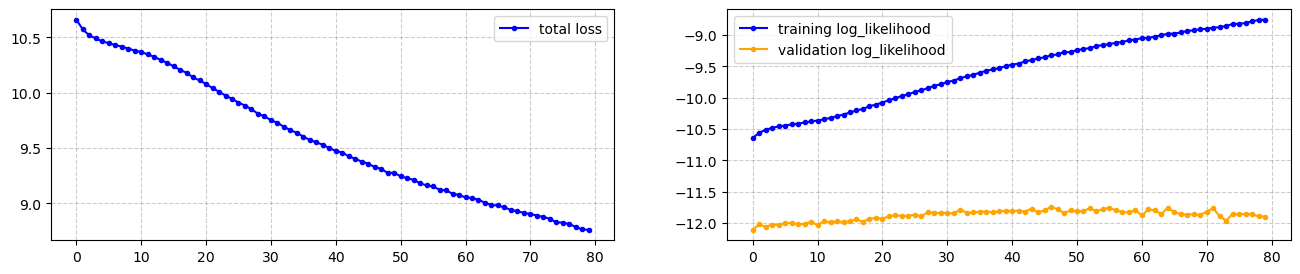

In [10]:
while True:
    try:
        # Log紀錄
        epoch += 1
        tr_loss = .0
        tr_LL = .0
        val_LL = .0

        # Training
        for batch in tr_dataloader:
            ## normal data
            mean, logvar, z_mean, z_logvar = model.train(batch)
            loss = criterion(mean, logvar, z_mean, z_logvar, batch)
            tr_LL += log_likelihood(mean, logvar.exp(), batch).item()

            ## abnormal data
            _, _, z_mean, z_logvar = model.train(data_aug(batch, .2, .1))
            loss += kl_divergence(z_mean, z_logvar)

            # backward
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            tr_loss += loss.item()

        # Validation
        with torch.no_grad():
            for batch in val_dataloader:
                mean, logvar, z_mean, z_logvar = model.train(batch)
                val_LL += log_likelihood(mean, logvar.exp(), batch).item()

        # Record Loss
        history += [[tr_loss/len(tr_data), tr_LL/len(tr_data), val_LL/len(val_data)]]

        # Start to draw
        clear_output()
        temp_hist = np.array(history)
        fig, ax = plt.subplots(1, 2, figsize = (16, 3))

        ## 畫數值
        ax[0].plot(temp_hist[:, 0], color = "blue", marker = '.', label = "total loss")
        ax[1].plot(temp_hist[:, 1], color = "blue", marker = ".", label = "training log_likelihood")
        ax[1].plot(temp_hist[:, 2], color = "orange", marker = ".", label = "validation log_likelihood")

        ## 畫窗格
        ax[0].grid(linestyle = "--", color = "gray", alpha = .4)
        ax[1].grid(linestyle = "--", color = "gray", alpha = .4)

        ## 畫標籤
        ax[0].legend()
        ax[1].legend()
        plt.show()

        if epoch == 80: break
    except KeyboardInterrupt:
        break

# Reconstruction Error

In [11]:
tr_distance = model.anomaly(tr)
val_distance = model.anomaly(val)
ts_distance = model.anomaly(ts)

training: 100%|███████████████████████████████████████████████████████████████████| 1555/1555 [00:05<00:00, 283.77it/s]


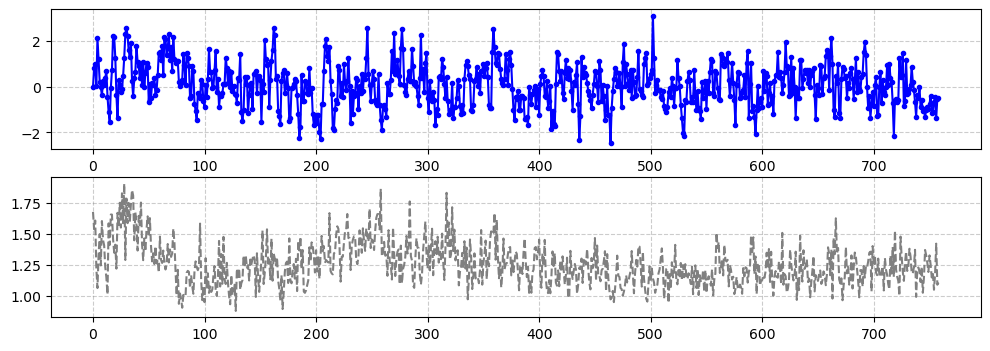

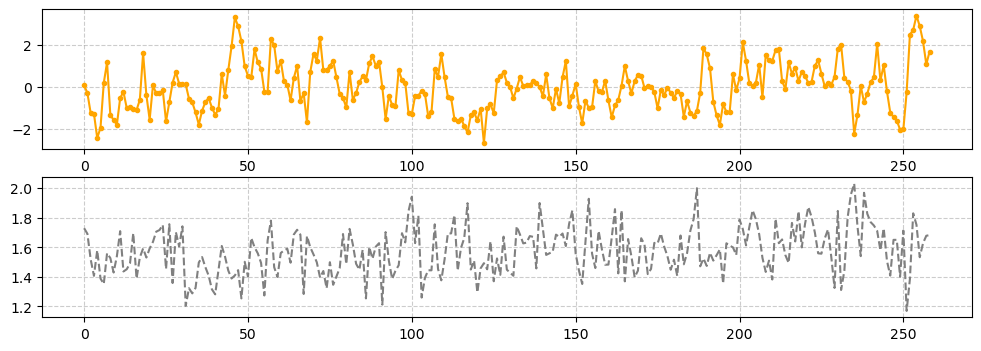

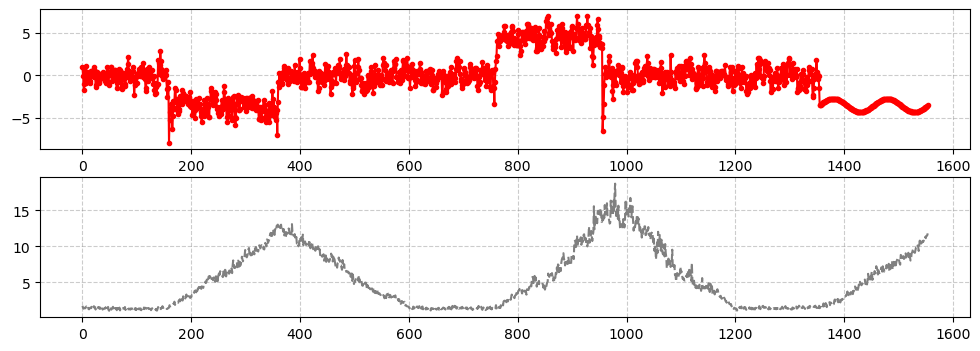

In [12]:
fig, ax = plt.subplots(2, 1, figsize = (12, 4))
ax[0].plot(tr[n_dim:], color = "blue", marker = ".")
ax[1].plot(tr_distance, color = "gray", linestyle = "--")
ax[0].grid(linestyle = "--", color = "gray", alpha = .4)
ax[1].grid(linestyle = "--", color = "gray", alpha = .4)
plt.show()

fig, ax = plt.subplots(2, 1, figsize = (12, 4))
ax[0].plot(val[n_dim:], color = "orange", marker = ".")
ax[1].plot(val_distance, color = "gray", linestyle = "--")
ax[0].grid(linestyle = "--", color = "gray", alpha = .4)
ax[1].grid(linestyle = "--", color = "gray", alpha = .4)
plt.show()

fig, ax = plt.subplots(2, 1, figsize = (12, 4))
ax[0].plot(ts[n_dim:], color = "red", marker = ".")
ax[1].plot(ts_distance, color = "gray", linestyle = "--")
ax[0].grid(linestyle = "--", color = "gray", alpha = .4)
ax[1].grid(linestyle = "--", color = "gray", alpha = .4)
plt.show()

# Reconstruction

In [13]:
def recon_sample(tr_set, val_set, ts_set):
    p = torch.tensor([1/tr_set.shape[0]]*tr_set.shape[0])
    tr_sample = tr_set[torch.multinomial(p, num_samples = 10, replacement = False)]
    p = torch.tensor([1/val_set.shape[0]]*val_set.shape[0])
    val_sample = val_set[torch.multinomial(p, num_samples = 10, replacement = False)]
    p = torch.tensor([1/ts_set.shape[0]]*ts_set.shape[0])
    ts_sample = ts_set[::10]

    return torch.cat((tr_sample, val_sample, ts_sample), dim = 0)

In [14]:
sample = recon_sample(tr_data, val_data, ts_data)

In [15]:
def plotting(choice):
    if choice in list(range(10)):
        color = "blue"
    elif choice in list(range(10, 20)):
        color = "orange"
    else:
        color = "red"

    fig, ax = plt.subplots(2, 1, figsize = (8, 6))
    ax[0].plot(sample[choice].reshape(-1, ).detach().cpu(), color = color)
    with torch.no_grad():
        pred, _, _, _ = model.train(sample[choice:choice+1])
    dist = float(torch.mean((sample[choice] - pred)**2))
    ax[0].plot(pred.detach().cpu().reshape(-1, ), color = "gray", linestyle = "--")
    ax[0].grid(linestyle = "--", color = "gray", alpha = .4)
    ax[0].set_title(f"Reconstruction {dist}")
    ax[1].plot(torch.fft.fft(sample[choice].reshape(-1, ).detach().cpu()).real, color = color)
    ax[1].plot(torch.fft.fft(pred.detach().cpu().reshape(-1, )).real, color = "gray", linestyle = "--")
    ax[1].grid(linestyle = "--", color = "gray", alpha = .4)
    plt.show()

interact(
    plotting,
    choice = list(range(len(sample)))
)

interactive(children=(Dropdown(description='choice', options=(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14…

<function __main__.plotting(choice)>

# Verify Test (For Sine Curve)

training: 100%|█████████████████████████████████████████████████████████████████████| 959/959 [00:03<00:00, 243.34it/s]


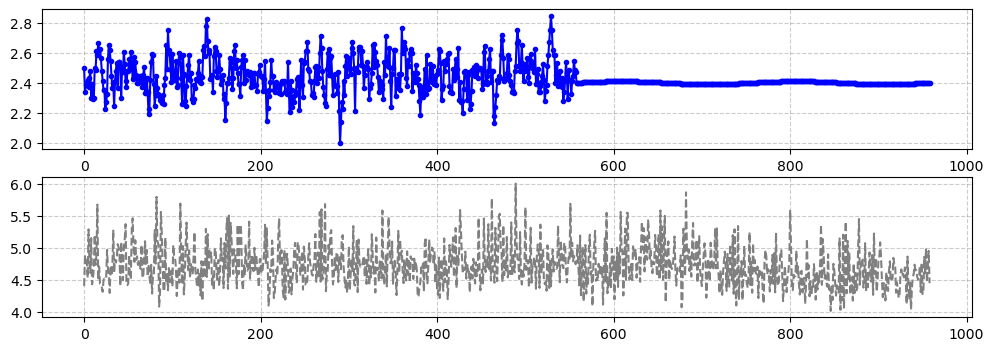

training: 100%|█████████████████████████████████████████████████████████████████████| 959/959 [00:03<00:00, 260.31it/s]


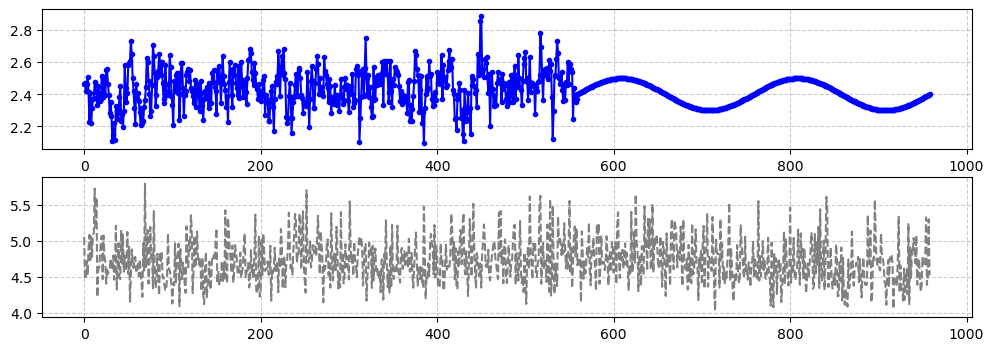

training: 100%|█████████████████████████████████████████████████████████████████████| 959/959 [00:03<00:00, 272.34it/s]


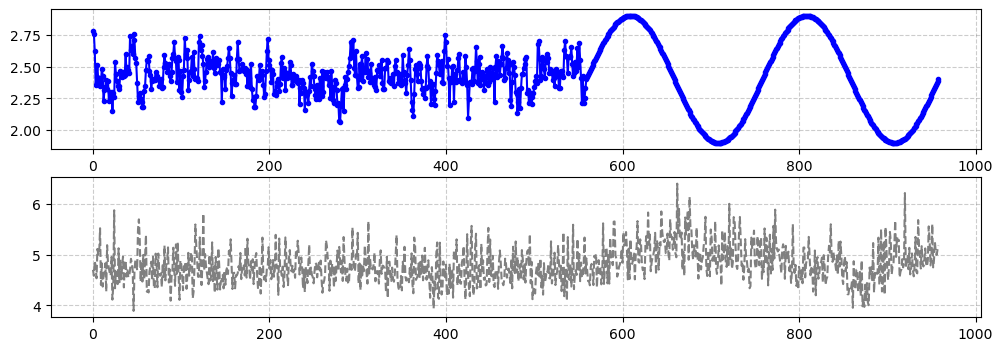

training: 100%|█████████████████████████████████████████████████████████████████████| 959/959 [00:03<00:00, 278.14it/s]


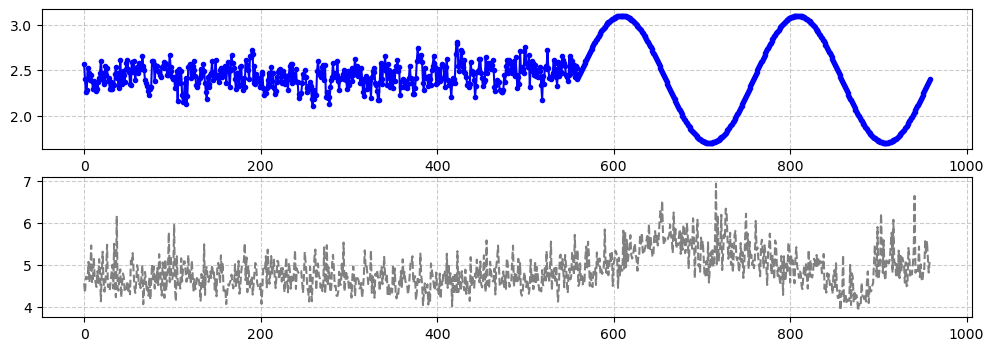

training: 100%|█████████████████████████████████████████████████████████████████████| 959/959 [00:03<00:00, 267.34it/s]


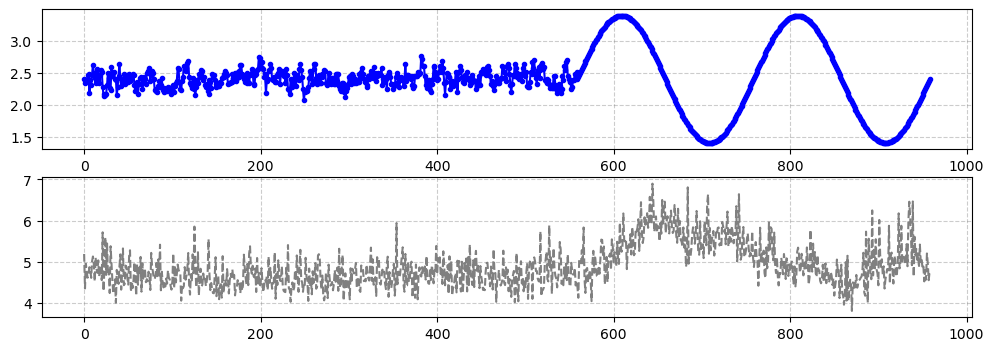

training: 100%|█████████████████████████████████████████████████████████████████████| 959/959 [00:03<00:00, 275.82it/s]


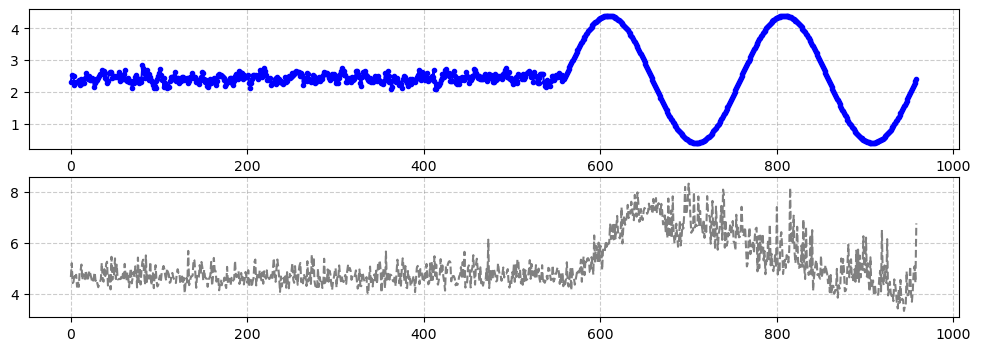

training: 100%|█████████████████████████████████████████████████████████████████████| 959/959 [00:03<00:00, 259.49it/s]


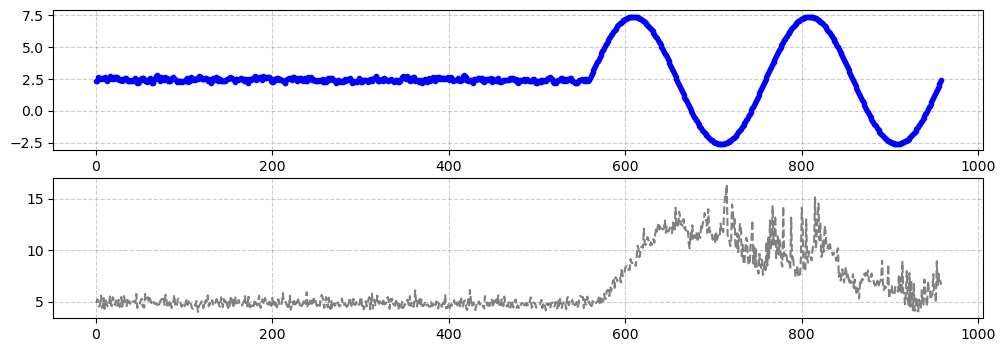

training: 100%|█████████████████████████████████████████████████████████████████████| 959/959 [00:03<00:00, 240.42it/s]


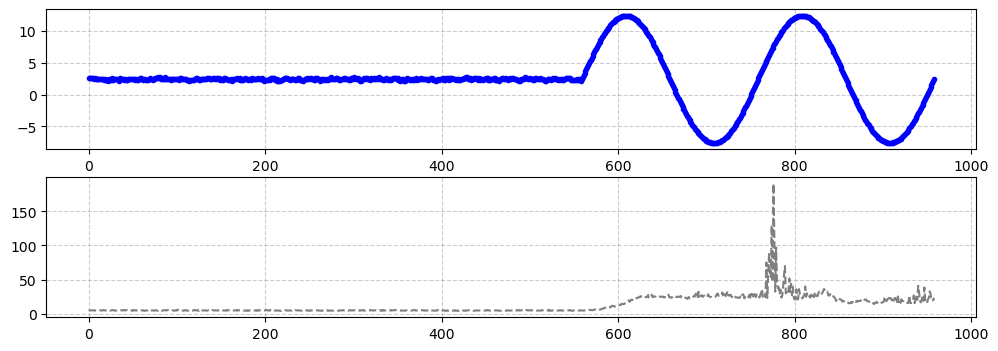

In [32]:
# AR with N(mu = 0, std = 0.1)
for i in (0.01, 0.1, 0.5, 0.7, 1, 2, 5, 10):
    print("="*100)
    verify = gen_sample(1, 0.59, 800) + (2.4 + i*np.sin(np.linspace(0, np.pi*4, 400))).tolist()
    Distance = model.anomaly(verify)
    fig, ax = plt.subplots(2, 1, figsize = (12, 4))
    ax[0].plot(verify[n_dim:], color = "blue", marker = ".")
    ax[1].plot(Distance, color = "gray", linestyle = "--")
    ax[0].grid(linestyle = "--", color = "gray", alpha = .4)
    ax[1].grid(linestyle = "--", color = "gray", alpha = .4)
    plt.show()